In [1]:
import torch
import numpy as np
import torchvision
import pandas as pd
import random as rd
import torch.nn as nn

from PIL import Image
from pathlib import Path
import torchvision.transforms as transforms

In [33]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Load Data

In [35]:
transform = transforms.Compose([
    transforms.ToTensor(),
])

In [12]:
train_dataset = torchvision.datasets.FashionMNIST(
    root='./data',
    download=True,
    train=True,
    transform=transform
)

test_dataset = torchvision.datasets.FashionMNIST(
    root='./data',
    download=True,
    train=False,
    transform=transform
)

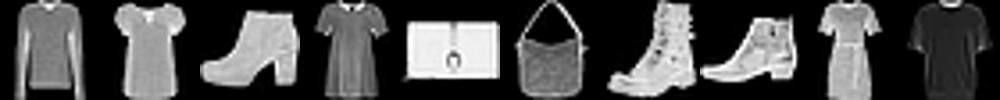

In [13]:
size = 100
final_image = Image.new('L', (size*10, size))

for i, idx in enumerate(rd.sample(range(0, train_dataset.data.shape[0]), 10)):

    image_array = np.array(train_dataset.data[idx, :, :], dtype=np.uint8).reshape((28, 28))
    image = Image.fromarray(image_array).resize((size, size))

    final_image.paste(image, (size*i, 0))

final_image


## Create Model

### encoder

In [36]:
batch_size = 64
num_classes = 10
learning_rate = 0.001
num_epochs = 20

In [25]:
class Encoder(nn.Module):

    def __init__(self, num_classes):
        super(Encoder, self).__init__()
        
        self.conv_layer1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3)
        self.conv_layer2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3)
        self.max_pool1 = nn.MaxPool2d(kernel_size = 2, stride = 2)
        
        self.conv_layer3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3)
        self.conv_layer4 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3)
        self.max_pool2 = nn.MaxPool2d(kernel_size = 2, stride = 2)
        
        self.fc1 = nn.Linear(1024, 128)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(128, num_classes)
    
    # Progresses data across layers    
    def forward(self, x):
        
        x = x.type(torch.float32)

        out = self.conv_layer1(x)
        out = self.conv_layer2(out)
        out = self.max_pool1(out)
        
        out = self.conv_layer3(out)
        out = self.conv_layer4(out)
        out = self.max_pool2(out)
                
        out = out.reshape(out.size(0), -1)
        
        out = self.fc1(out)
        out = self.relu1(out)
        out = self.fc2(out)

        return out
    

In [26]:
train_loader = torch.utils.data.DataLoader(dataset = train_dataset,
                                           batch_size = batch_size,
                                           shuffle = True)


test_loader = torch.utils.data.DataLoader(dataset = test_dataset,
                                           batch_size = batch_size,
                                           shuffle = True)

In [37]:
model = Encoder(10)

criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay = 0.005, momentum = 0.9)  

total_step = len(train_loader)

In [ ]:
for epoch in range(num_epochs):

    for i, (images, labels) in enumerate(train_loader):  

        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, 2, loss.item()))